In [1]:
from dataloaders import data_set,data_dict
import torch
import yaml
import os
import torch.nn as nn

import torch
import torch.optim as optim

from experiment import Exp
from experiment import MixUpLoss

from dataloaders import data_set,data_dict
from models.model_builder import model_builder


import numpy as np

import pbtexperiment as pb
import random

from utils import adjust_learning_rate_class
from ray.tune.schedulers.pb2 import PB2

/home/janis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-21 14:56:21,100	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-08-21 14:56:21,147	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
config_path = os.path.abspath('configs/data.yaml')
#model_config = os.path.abspath('configs/model.yaml')
model_config = 'configs/model.yaml'
root_path = os.path.abspath("datasets")
to_save_path = os.path.abspath("ISWC2022LearnableFilter/Run_logs")   
freq_save_path = os.path.abspath("ISWC2022LearnableFilter/Freq_data")
window_save_path = os.path.abspath("ISWC2022LearnableFilter/Sliding_window")

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def get_args():
    args = dotdict()   

    args.seed = 1

    # TODO change the path as relative path
    args.to_save_path     = to_save_path
    args.freq_save_path   = freq_save_path
    args.window_save_path = window_save_path
    args.root_path        = root_path

    args.drop_transition  = False
    args.datanorm_type    = "standardization" # None ,"standardization", "minmax"

    args.batch_size       = 256                                                    
    args.shuffle          = True
    args.drop_last        = False
    args.train_vali_quote = 0.90                                           


    # training setting 
    args.train_epochs            = 150

    args.learning_rate           = 0.001  
    args.learning_rate_patience  = 5
    args.learning_rate_factor    = 0.1


    args.early_stop_patience     = 40

    args.use_gpu                 = True if torch.cuda.is_available() else False
    args.gpu                     = 0
    #args.use_multi_gpu           = False

    args.optimizer               = "Adam"
    args.criterion               = "CrossEntropy"

    args.data_name                        =  "dg"
    args.use_vali_keys = True
    #args.exp_mode            = "LOCV"
    args.exp_mode            = "Given"

    args.wavelet_filtering                = False
    args.wavelet_filtering_regularization = False
    args.wavelet_filtering_finetuning     = False


    args.difference       = True 
    args.filtering        = True
    args.magnitude        = False
    args.weighted_sampler = False

    args.pos_select       = None
    args.sensor_select    = None


    args.representation_type = "time"

  #  if args.data_name      ==  "skodar":
  #      args.exp_mode            = "SOCV"

    config_file = open(config_path, mode='r')
    data_config = yaml.load(config_file, Loader=yaml.FullLoader)
    config = data_config[args.data_name]

    args.root_path       = os.path.join(args.root_path,config["filename"])
    args.sampling_freq   = config["sampling_freq"]
    args.num_classes     =  config["num_classes"]
    window_seconds       = config["window_seconds"]
    args.windowsize      =   int(window_seconds * args.sampling_freq) 
    args.input_length    =  args.windowsize
    # input information
    args.c_in            = config["num_channels"]
    
    if args.difference:
        args.c_in  = args.c_in * 2
    if  args.filtering :
        for col in config["sensors"]:
            if "acc" in col:
                args.c_in = args.c_in+1

    if args.wavelet_filtering :
        
        if args.windowsize%2==1:
            N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
        else:
            N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

        args.f_in            =  args.number_wavelet_filtering*N_ds+1
    else:
        args.f_in            =  1


    args.filter_scaling_factor = 0.25
    args.model_type            = "deepconvlstm"
    args.model_config = model_config

    args.random_aug_first = 1
    args.random_augmentation_prob = 0.5
    args.mixup_probability  = 0.5
    args.mixup_alpha  = 0.5
    args.mixup_argmax = True

    args.max_aug = 3

    args.random_augmentation_config = {
                "jitter":1,
                #self.exponential_smoothing,
                "moving_average":1,
                "magnitude_scaling":1,
                "magnitude_warp":1,
                "magnitude_shift":1,
                "time_warp":1,
                "window_warp":1,
                "window_slice":1,
                "random_sampling":1,
                "slope_adding":1,
            }
    random_augmentation_nr = 0
    for key in args.random_augmentation_config.keys():
        if args.random_augmentation_config[key]==1:
            random_augmentation_nr = random_augmentation_nr+1
    args.random_augmentation_nr = random_augmentation_nr

    return args

Use GPU: cuda:0
Build the DeepConvLSTM model!
Done!
Parameter : 63698
Set the seed as :  0
 ----------------------- load all the data -------------------
Channel Augmentation : Differencing
Channel Augmentation : Acc Gyro Filtering
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------
================ Given Mode ====================
================ 1 CV ======================
================ the 0 th CV Experiment ================ 
[-] Target sampling weights:  [3.73287543e-05 3.92003136e-04]
Train data number :  29340
The number of classes is :  2
The input_length  is :  64
The channel_in is :  27
Validation data number :  3480
Test data number :  15093
================ Build the model ================ 
Build the DeepConvLSTM model!
Epoch: 1 cost time: 27.385245084762573
VALI: Epoch: 1, Steps: 115 | Train Loss: 0.3020559  Vali Loss: 0.3679406 Vali Accuracy: 0.8451149  Vali weighted F1: 0.77

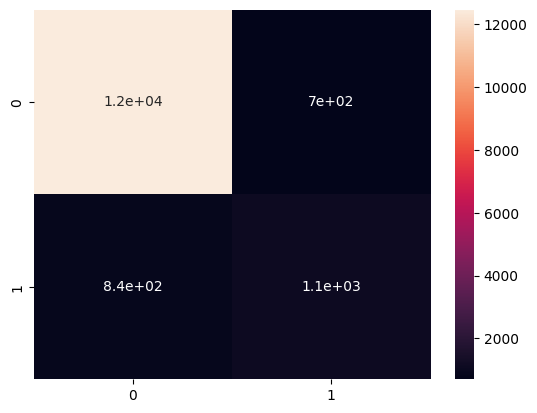

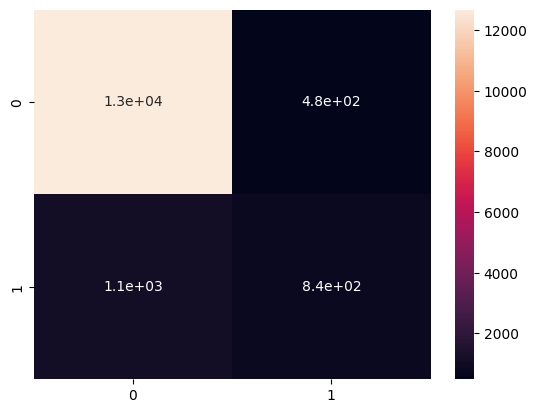

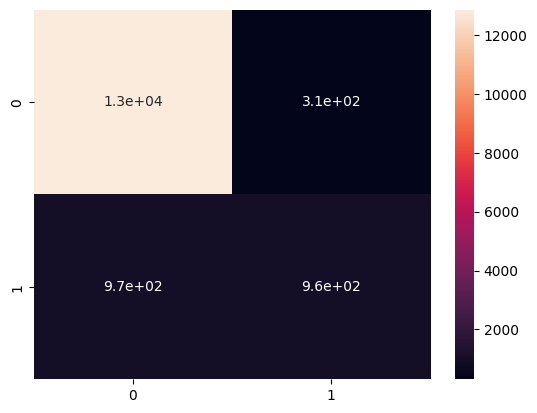

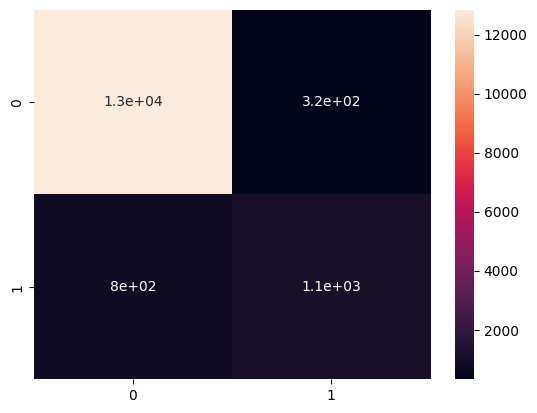

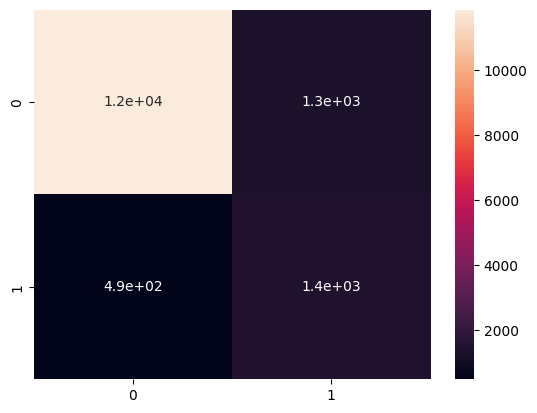

In [3]:

for i in range(5):
    args = get_args()
    args.seed = i
    exp = Exp(args)

    exp.train()